# Knowledge Distillation for Convolutional Networks
Following: https://medium.com/analytics-vidhya/knowledge-distillation-for-convolutional-networks-e73682c611e8

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

In [2]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torch import nn, optim
import torch.backends.cudnn as cudnn

In [3]:
# Ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2560
trainset = torchvision.datasets.CIFAR10(root='/mnt/d/PublicData/CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='/mnt/d/PublicData/CIFAR10', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

len_trainset = len(trainset)
len_valset = len(valset)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device_id = torch.cuda.device_count()
print(device_id)

# device = torch.device("cuda:0,1,2,3" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# https://stackoverflow.com/questions/54216920/how-to-use-multiple-gpus-in-pytorch

4


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([2560, 3, 32, 32])
torch.Size([2560])


In [6]:
resnet = models.resnet50(pretrained=False)
for param in resnet.parameters():
    param.requires_grad = False
    
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)
resnet = nn.DataParallel(resnet)
resnet = resnet.to(device)
# cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.module.fc.parameters())

In [7]:
def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs=25):
    model.train()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history_train = torch.empty(0,2)
    history_validate = torch.empty(0,2)
#     print(history)
    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() 
            optimizer.step()  
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len_trainset
        epoch_acc = running_corrects.double() / len_trainset
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc)) 
        history_train = torch.cat([history_train,torch.FloatTensor([[epoch_acc, epoch_loss]])],dim=0)
        model.eval()
        running_loss_val = 0.0 
        running_corrects_val = 0
        for inputs, labels in valloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs, 1)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / len_valset
        epoch_acc_val = running_corrects_val.double() / len_valset

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        print('Best val Acc: {:4f}'.format(best_acc))
        history_validate = torch.cat([history_validate,torch.FloatTensor([[epoch_acc_val,epoch_loss_val]])],dim=0)
#         print(history)
        model.load_state_dict(best_model_wts)
    return model, history_train, history_validate

In [8]:
resnet_teacher, history_train_teacher, history_validate_teacher = train_and_evaluate(resnet,trainloader, valloader,criterion,optimizer, len_trainset,len_valset,5000)

Epoch 0/4999
----------
Train Loss: 2.6130 Acc: 0.1177
Val Loss: 2.4497 Acc: 0.1043
Best val Acc: 0.104300
Epoch 1/4999
----------
Train Loss: 2.3547 Acc: 0.1407
Val Loss: 2.4568 Acc: 0.1047
Best val Acc: 0.104700
Epoch 2/4999
----------
Train Loss: 2.2841 Acc: 0.1574
Val Loss: 2.2667 Acc: 0.1534
Best val Acc: 0.153400
Epoch 3/4999
----------
Train Loss: 2.2385 Acc: 0.1717
Val Loss: 2.2438 Acc: 0.1714
Best val Acc: 0.171400
Epoch 4/4999
----------
Train Loss: 2.2092 Acc: 0.1853
Val Loss: 2.2299 Acc: 0.1801
Best val Acc: 0.180100
Epoch 5/4999
----------
Train Loss: 2.1914 Acc: 0.1972
Val Loss: 2.2171 Acc: 0.1855
Best val Acc: 0.185500
Epoch 6/4999
----------
Train Loss: 2.1675 Acc: 0.2051
Val Loss: 2.2094 Acc: 0.1911
Best val Acc: 0.191100
Epoch 7/4999
----------
Train Loss: 2.1562 Acc: 0.2102
Val Loss: 2.2033 Acc: 0.1911
Best val Acc: 0.191100
Epoch 8/4999
----------
Train Loss: 2.1573 Acc: 0.2106
Val Loss: 2.1954 Acc: 0.1892
Best val Acc: 0.191100
Epoch 9/4999
----------
Train Loss: 2

In [9]:
def evalue_chart_acc_and_loss(history_acc_loss, chart_name):
    num_epochs = len(history_acc_loss)
    history_chart_acc = [h.cpu().numpy()[0] for h in history_acc_loss]
    history_chart_losses = [h.cpu().numpy()[1] for h in history_acc_loss]
    
    plt.title("{} Accuracy vs. Number of Epochs".format(chart_name))
    plt.xlabel("{} Epochs".format(chart_name))
    plt.ylabel("{} Accuracy".format(chart_name))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.plot(range(1,num_epochs+1),history_chart_acc,label="{} - Accurancy".format(chart_name),color='blue')
    plt.legend()
    plt.show()

    plt.title("{} Loss vs. Number of Epochs".format(chart_name))
    plt.xlabel("{} Epochs".format(chart_name))
    plt.ylabel("{} Loss".format(chart_name))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.plot(range(1,num_epochs+1),history_chart_losses,label="{} - Loss".format(chart_name), color='orange')
    plt.legend()
    plt.show()

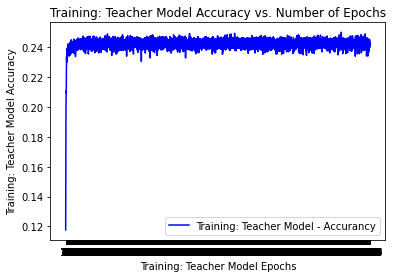

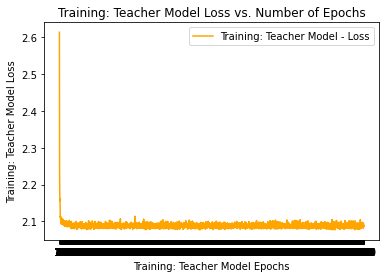

In [10]:
evalue_chart_acc_and_loss(history_train_teacher, "Training: Teacher Model")

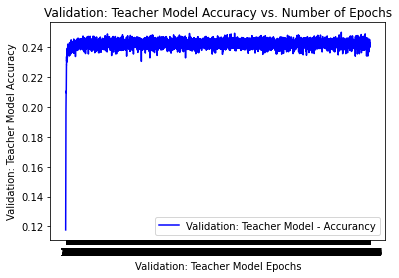

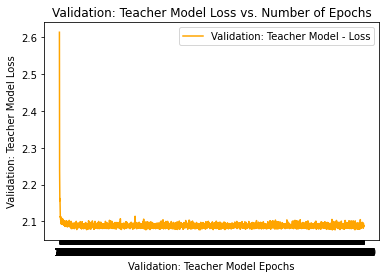

In [11]:
evalue_chart_acc_and_loss(history_train_teacher, "Validation: Teacher Model")

In [12]:
class Net(nn.Module):
    """
    This will be your student network that will learn from the 
    teacher network in our case resnet50.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
            dilation=1, ceil_mode=False)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
            dilation=1, ceil_mode=False)
        )
        self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout_rate = 0.5
   
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
net = Net().to(device)

In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
out = net(images.cuda())
print(out.shape)

torch.Size([2560, 10])


In [14]:
def loss_kd(outputs, labels, teacher_outputs, temparature, alpha):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temparature, dim=1),F.softmax(teacher_outputs/temparature,dim=1)) * (alpha * temparature * temparature) + F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss

def get_outputs(model, dataloader):
    '''
    Used to get the output of the teacher network
    '''
    outputs = []
    for inputs, labels in dataloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        outputs.append(output)
    return outputs

In [15]:
def train_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for i,(images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_teacher = teacher_out[i].to(device)
        loss = loss_kd(outputs,labels,outputs_teacher,temparature, alpha)
        _, preds = torch.max(outputs, 1)
        loss.backward(retain_graph=True) #https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795/4
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects.double() / len(trainset)
    print('train_kd - Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    history = torch.FloatTensor([[epoch_acc, epoch_loss]])
    return history

def eval_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i,(images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs_teacher = teacher_out[i].to(device)
        loss = loss_kd(outputs,labels,outputs_teacher,temparature, alpha)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(valset)
    epoch_acc = running_corrects.double() / len(valset)
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return epoch_acc, epoch_loss

def train_and_evaluate_kd(model, teacher_model, optimizer, loss_kd, trainloader, valloader, temparature, alpha, num_epochs=25):
    teacher_model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    outputs_teacher_train = get_outputs(teacher_model, trainloader)
    outputs_teacher_val = get_outputs(teacher_model, valloader)
    
    history_evaluation = torch.empty(0,2)
    history_train = torch.empty(0,2)
    print("Teacher’s outputs are computed now starting the training process-")
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training the student with the soft labes as the outputs from the teacher and using the loss_kd function
        train_kd_history = train_kd(model, outputs_teacher_train, optim.Adam(net.parameters()),loss_kd,trainloader, temparature, alpha)
        print(train_kd_history)
        history_train = torch.cat([history_train,train_kd_history],dim=0)
#         evalue_chart_acc_and_loss(train_kd_history, "Training Knowledge Distillation")

        # Evaluating the student network
        epoch_acc_val, epoch_loss_val = eval_kd(model, outputs_teacher_val, optim.Adam(net.parameters()), loss_kd, valloader, temparature, alpha)
        history_evaluation = torch.cat([history_evaluation,torch.FloatTensor([[epoch_acc_val, epoch_loss_val]])],dim=0)
        
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Best val Acc: {:4f}'.format(best_acc))
            model.load_state_dict(best_model_wts)
    return model, history_evaluation, history_train

In [16]:
student_net = nn.DataParallel(net)
student_net = student_net.to(device)

In [17]:
student_model, student_hist_eval, studen_hist_train = train_and_evaluate_kd(student_net,resnet_teacher, optim.Adam(net.parameters()),loss_kd,trainloader,valloader,1,0.5,5000)

Teacher’s outputs are computed now starting the training process-
Epoch 0/4999
----------


/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/torch/nn/functional.py:2607: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train_kd - Train Loss: 1.1057 Acc: 0.1801
tensor([[0.1801, 1.1057]])
Val Loss: 1.0530 Acc: 0.2407
Best val Acc: 0.240700
Epoch 1/4999
----------
train_kd - Train Loss: 1.1015 Acc: 0.1930
tensor([[0.1930, 1.1015]])
Val Loss: 1.0644 Acc: 0.2385
Epoch 2/4999
----------
train_kd - Train Loss: 1.0310 Acc: 0.2453
tensor([[0.2453, 1.0310]])
Val Loss: 0.9793 Acc: 0.2598
Best val Acc: 0.259800
Epoch 3/4999
----------
train_kd - Train Loss: 1.0750 Acc: 0.2185
tensor([[0.2185, 1.0750]])
Val Loss: 1.0225 Acc: 0.2348
Epoch 4/4999
----------
train_kd - Train Loss: 0.9793 Acc: 0.2868
tensor([[0.2868, 0.9793]])
Val Loss: 0.9207 Acc: 0.3339
Best val Acc: 0.333900
Epoch 5/4999
----------
train_kd - Train Loss: 1.0115 Acc: 0.2894
tensor([[0.2894, 1.0115]])
Val Loss: 0.9470 Acc: 0.3211
Epoch 6/4999
----------
train_kd - Train Loss: 0.9500 Acc: 0.3140
tensor([[0.3140, 0.9500]])
Val Loss: 0.9001 Acc: 0.3443
Best val Acc: 0.344300
Epoch 7/4999
----------
train_kd - Train Loss: 0.9341 Acc: 0.3272
tensor([[0.3

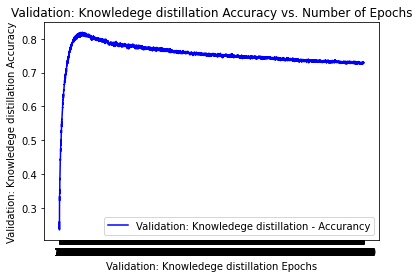

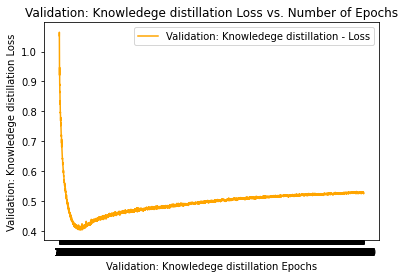

In [18]:
evalue_chart_acc_and_loss(student_hist_eval, "Validation: Knowledege distillation")

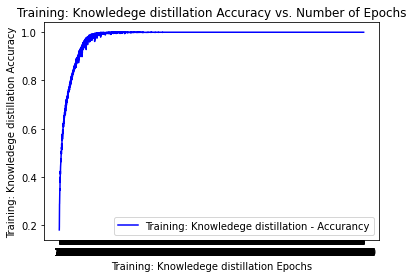

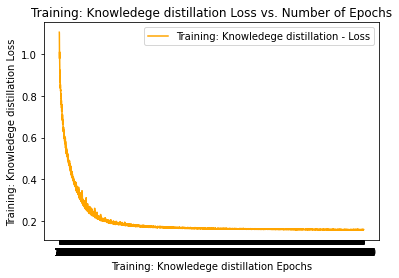

In [19]:
evalue_chart_acc_and_loss(studen_hist_train, "Training: Knowledege distillation")